# 🎴 Yu-Gi-Oh! PPSSPP Texture Mapper

This notebook automates the creation of a `textures.ini` file for PPSSPP.

It works by comparing a folder of **hashed, low-quality (LQ) English textures (Set A)** with a folder of **cleanly-named, LQ Japanese textures (Set C)**.

It uses **perceptual hashing on a cropped 78x60 region** of each image to find matches. It then generates the `.ini` file that maps your Set A hashes to the clean filenames, which you can then use with your **high-quality (HQ) replacement textures (Set B)**.

### Workflow:
1.  **Setup:** Install required libraries.
2.  **Configuration:** Set your folder paths.
3.  **Run Cell 1:** Build the hash database from Set C (with caching).
4.  **Run Cell 2:** Find all matches by comparing Set A to the database.
5.  **Run Cell 3 & 4:** Visualize and spot-check the matches to confirm accuracy.
6.  **Run Cell 5:** Write the final `textures.ini` file.

In [1]:
# --- 1. Setup: Install Libraries ---
# Run this cell once to install the necessary packages.
!pip install imagehash Pillow matplotlib

In [2]:
# --- Import Libraries ---
import imagehash
import os
import pickle
import random
import time
from PIL import Image
import matplotlib.pyplot as plt

# This command makes plots appear directly in the notebook
%matplotlib inline

## ⚙️ Configuration

**IMPORTANT:** Set all your paths and options in the cell below before you begin.

In [ ]:
# --- Configuration ---
# 1. Path to your HASHED English dump (Set A)
set_a_folder = r"D:\My Stuff\My Yu-Gi-Oh\Card Art Edits\TF Mod\TF1\missinghash"

# 2. Path to your CLEANLY-NAMED Japanese dump (Set C)
set_c_folder = r"D:\Stuff\Game Mods\Yu-Gi-Oh! Tag Force Series\Tools\Original Japanese ISO card images\cardh_j"

# 3. Path where you want the final textures.ini to be saved
output_ini_file = r"D:\My Stuff\My Yu-Gi-Oh\Card Art Edits\TF Mod\TF1\missinghash\textures.ini"

# 4. How "similar" images must be to match (0 is identical, 1-5 is very close).
#    Start with 1. If you miss some, try 5.
hash_similarity_threshold = 10

# 5. Filename for the hash database cache
cache_filename = "hash_database.cache"

# 6. Crop box: (left, upper, right, lower).
crop_box = (0, 0, 78, 60)  # Top-left 78x60 pixels
# ---------------------

## Step 1: Build Hash Database (Set C)

This cell defines the helper functions and builds the hash database from your **Set C (Japanese)** images. 

It will create a `hash_database.cache` file in your Set C folder so that the next time you run it, it will load instantly.

In [4]:
def get_cropped_hash(img_path, crop_box):
    """Helper function to open, crop (78x60), and hash an image."""
    with Image.open(img_path) as img:
        cropped_img = img.crop(crop_box)
        return imagehash.dhash(cropped_img)

def build_hash_database(folder_path, crop_box, cache_file_name):
    """Scans Set C and creates a database of {image_hash: "clean_filename.png"}."""
    print(f"--- Phase 1: Building/Loading hash database from {folder_path} ---")
    
    cache_file_path = os.path.join(folder_path, cache_file_name)
    
    # --- Caching Logic ---
    if os.path.exists(cache_file_path):
        try:
            print(f"  Found cache file! Loading from {cache_file_path}...")
            with open(cache_file_path, 'rb') as f:
                database = pickle.load(f)
            print(f"--- Database load complete. Indexed {len(database)} images from cache. ---")
            return database
        except Exception as e:
            print(f"  Warning: Could not load cache file. Rebuilding. Error: {e}")

    # --- If cache not found or failed, build it ---
    print("  No valid cache found. Building database from images...")
    database = {}
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            try:
                img_path = os.path.join(folder_path, filename)
                img_hash = get_cropped_hash(img_path, crop_box) 
                database[img_hash] = filename
                count += 1
                if count % 500 == 0:
                    print(f"  ...indexed {count} images.")
            except Exception as e:
                print(f"  Warning: Could not process {filename}. Error: {e}")
    
    # --- Save to cache ---
    try:
        print(f"  Saving database to cache file: {cache_file_path}")
        with open(cache_file_path, 'wb') as f:
            pickle.dump(database, f)
    except Exception as e:
        print(f"  Warning: Could not save cache file. Error: {e}")

    print(f"--- Database build complete. Indexed {count} images. ---")
    return database

# --- Run Step 1 ---
print("Starting Step 1...")
start_time = time.time()
try:
    hash_db = build_hash_database(set_c_folder, crop_box, cache_filename)
except FileNotFoundError as e:
    print(f"\n*** FATAL ERROR ***")
    print(f"Could not find folder: {e.filename}")
    print("Please check your 'set_c_folder' path in the Configuration cell.")
    hash_db = None
end_time = time.time()
print(f"Step 1 finished in {end_time - start_time:.2f} seconds.")

Starting Step 1...
--- Phase 1: Building/Loading hash database from D:\Stuff\Game Mods\Yu-Gi-Oh! Tag Force Series\Tools\Original Japanese ISO card images\cardh_j ---
  Found cache file! Loading from D:\Stuff\Game Mods\Yu-Gi-Oh! Tag Force Series\Tools\Original Japanese ISO card images\cardh_j\hash_database.cache...
--- Database load complete. Indexed 7233 images from cache. ---
Step 1 finished in 0.12 seconds.


## Step 2: Find Matches (Set A)

This cell scans your **Set A (English Hashed)** images, compares their cropped hashes to the database, and finds all matches. 

It will store the matches in a list called `all_matches` for visualization and a list called `all_ini_entries` for the final file.

In [5]:
def find_matches(set_a_path, set_c_path, database, threshold, crop_box):
    """Scans Set A, compares with the database, and returns matches."""
    print(f"--- Phase 2: Matching hashes from {set_a_path} ---")
    
    # matches: Stores tuples of (hash_filepath, matched_filepath, ini_line)
    matches = []
    # ini_entries: Stores just the text line to avoid duplicates
    ini_entries = set()
    
    total_files = 0
    matches_found = 0
    
    if not database:
        print("Error: Hash database is empty. Cannot run matching.")
        return [], []
    
    for filename_a in os.listdir(set_a_path):
        if not filename_a.endswith(".png"):
            continue
            
        total_files += 1
        try:
            img_a_path = os.path.join(set_a_path, filename_a)
            hash_a = get_cropped_hash(img_a_path, crop_box)
            
            best_match_filename = None
            
            # First, check for a perfect (distance=0) match
            if hash_a in database:
                best_match_filename = database[hash_a]
            
            # If no perfect match, check for a "close enough" match
            elif threshold > 0:
                for hash_c, filename_c in database.items():
                    distance = hash_a - hash_c
                    if distance <= threshold:
                        best_match_filename = filename_c
                        break # Found a close enough match
            
            # If we found a match...
            if best_match_filename:
                ppsspp_hash = os.path.splitext(filename_a)[0]
                ini_line = f"{ppsspp_hash} = {best_match_filename}"
                
                # Add to set to prevent duplicate INI entries
                if ini_line not in ini_entries:
                    ini_entries.add(ini_line)
                    
                    # Store full paths for visualization
                    matched_file_path = os.path.join(set_c_path, best_match_filename)
                    matches.append((img_a_path, matched_file_path, ini_line))
                    matches_found += 1
                
            if total_files % 500 == 0:
                print(f"  ...scanned {total_files} files. Found {matches_found} unique matches.")
                
        except Exception as e:
            print(f"  Warning: Could not process {filename_a}. Error: {e}")

    print(f"--- Matching complete. ---")
    print(f"  Total files in Set A scanned: {total_files}")
    print(f"  Total unique matches found:   {len(ini_entries)}")
    
    return matches, list(ini_entries)

# --- Run Step 2 ---
print("Starting Step 2...")
start_time = time.time()
try:
    all_matches, all_ini_entries = find_matches(set_a_folder, set_c_folder, hash_db, hash_similarity_threshold, crop_box)
except FileNotFoundError as e:
    print(f"\n*** FATAL ERROR ***")
    print(f"Could not find folder: {e.filename}")
    print("Please check your 'set_a_folder' path in the Configuration cell.")
    all_matches, all_ini_entries = [], []
end_time = time.time()
print(f"Step 2 finished in {end_time - start_time:.2f} seconds.")

Starting Step 2...
--- Phase 2: Matching hashes from D:\My Stuff\My Yu-Gi-Oh\Card Art Edits\TF Mod\TF1\missinghash ---
  ...scanned 500 files. Found 209 unique matches.
--- Matching complete. ---
  Total files in Set A scanned: 606
  Total unique matches found:   253
Step 2 finished in 6.07 seconds.


## Step 3: Visualize & Verify Matches

This is the **verification step**. Run the cell below to define the `visualize_match` function. Then, run the cell after that to **see a random matched pair**. 

You can run the second cell multiple times to spot-check different random matches.

**This will show you the cropped 78x60 images that were compared.** If the two images don't look like the same card, your `hash_similarity_threshold` is probably too high! Go back to the Configuration cell, lower it, and re-run Step 2.

In [6]:
# --- Define the visualization function ---

def visualize_match(match_tuple, crop_box):
    """Displays a side-by-side comparison of a matched pair (A vs C)."""
    hash_file, matched_file, ini_line = match_tuple
    
    try:
        # Open and crop both images to show exactly what was compared
        img_a = Image.open(hash_file).crop(crop_box)
        img_c = Image.open(matched_file).crop(crop_box)
    except FileNotFoundError as e:
        print(f"Error loading image: {e}")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(img_a)
    ax1.set_title(f"Set A (Hashed): {os.path.basename(hash_file)}")
    ax1.axis('off')
    
    ax2.imshow(img_c)
    ax2.set_title(f"Set C (Matched): {os.path.basename(matched_file)}")
    ax2.axis('off')
    
    plt.suptitle(f"Generated INI line: {ini_line}", y=0.9)
    plt.tight_layout()
    plt.show()

print("Visualization functions defined.")

Visualization functions defined.


Displaying a random match...


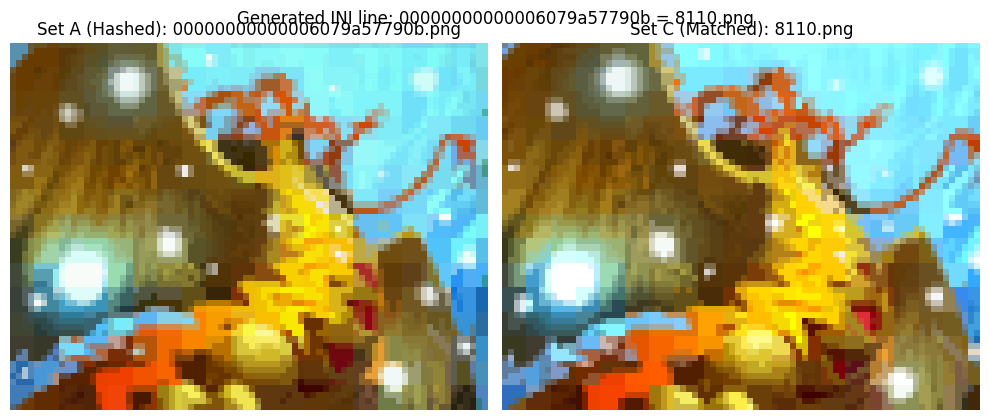

In [43]:
# --- Run this cell to see a random match ---
# You can run this cell multiple times!

if all_matches:
    print("Displaying a random match...")
    random_match = random.choice(all_matches)
    visualize_match(random_match, crop_box)
else:
    print("No matches found to visualize.")

In [8]:
# --- Optional: Visualize a specific match by index ---
# (Uncomment the lines below to use)

# if all_matches and len(all_matches) > 50:
#     print("Displaying match at index 50...")
#     visualize_match(all_matches[50], crop_box)
# else:
#     print("Not enough matches to show index 50.")

## Step 4: Write `textures.ini` File

Once you are satisfied with the matches you've spot-checked, run this final cell. 

It will write all the unique INI lines it found into your target `textures.ini` file.

In [9]:
def write_ini_file(output_path, ini_entries):
    """Writes the final .ini file to disk."""
    print(f"--- Phase 4: Writing {len(ini_entries)} entries to {output_path} ---")
    try:
        with open(output_path, "w") as f:
            f.write("[hashes]\n")
            # Sort the entries for a clean file
            sorted_entries = sorted(ini_entries)
            for line in sorted_entries:
                f.write(line + "\n")
        print(f"\n*** SUCCESS! ***")
        print(f"Generated {output_path} with {len(ini_entries)} entries.")
    except Exception as e:
        print(f"\n*** ERROR! ***")
        print(f"Could not write to {output_path}. Error: {e}")
        print("Please check your 'output_ini_file' path in the Configuration cell.")

# --- Run Step 4 ---
if all_ini_entries:
    write_ini_file(output_ini_file, all_ini_entries)
else:
    print("No INI entries to write. Did the matching step find anything?")

--- Phase 4: Writing 253 entries to D:\My Stuff\My Yu-Gi-Oh\Card Art Edits\TF Mod\TF1\missinghash\textures.ini ---

*** SUCCESS! ***
Generated D:\My Stuff\My Yu-Gi-Oh\Card Art Edits\TF Mod\TF1\missinghash\textures.ini with 253 entries.
